In [1]:
! pip install kaggle
! kaggle datasets download puneet6060/intel-image-classification
! unzip -n -d dataset intel-image-classification.zip

Defaulting to user installation because normal site-packages is not writeable
intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  intel-image-classification.zip


# Imports

In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

2023-12-04 18:38:37.896793: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 18:38:37.896842: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 18:38:37.898362: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 18:38:38.022143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
data_path = "dataset"
model_path = "model"

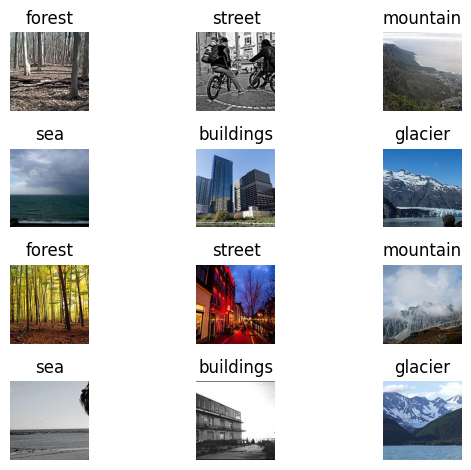

In [5]:
training_path = os.path.join(data_path, "seg_train/seg_train")
validation_path = os.path.join(data_path, "seg_test/seg_test")
training_subdirs = os.listdir(training_path)
validation_subdirs = os.listdir(validation_path)

training_images = [os.path.join(os.path.join(training_path, dir), (os.listdir(os.path.join(training_path, dir))[0])) for dir in os.listdir(training_path)]
validation_images = [os.path.join(os.path.join(validation_path, dir), (os.listdir(os.path.join(validation_path, dir))[0])) for dir in os.listdir(validation_path)]
training_images = [Image.open(image) for image in training_images]
validation_images = [Image.open(image) for image in validation_images]
fig, axs = plt.subplots(nrows=4, ncols=3)
for i, ax in enumerate(axs):
    for j, slot in enumerate(ax):
        slot.axis('off')
        if i < 2:
            slot.imshow(training_images[i*len(ax) + j])
            slot.set_title(f"{training_subdirs[i*len(ax) + j]}")
        else:
            slot.imshow(validation_images[(i-2)*len(ax) + j])
            slot.set_title(f"{validation_subdirs[(i-2)*len(ax) + j]}")
fig.tight_layout()
plt.show()

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                rotation_range=10,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=False,
                fill_mode='nearest',
                brightness_range=[0.8, 1.2])
validation_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


class_names = list(train_generator.class_indices.keys())

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


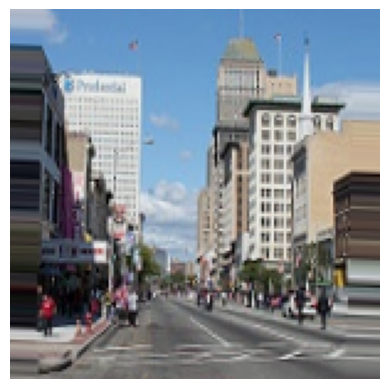

In [7]:
plt.axis('off')
plt.imshow((train_generator[0][0][0]).astype('uint8'))
plt.show()

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential([
  layers.Rescaling(1.0/255.0, input_shape=(150,150,3)),
  layers.Conv2D(128, 3, activation='relu'),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(5),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(5),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(6, name="outputs", activation='softmax')
])

print(model.summary())

2023-12-04 18:38:43.932797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 18:38:43.955886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 18:38:43.955922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 18:38:43.957363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 18:38:43.957399: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      73792     
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        73792     
                                                        

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath=os.path.join(model_path, "model.hdf5"), save_best_only=True, verbose=1)
tb = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=1)

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

network_history = model.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=1, callbacks=[early_stopping, checkpointer, tb])

2023-12-04 18:38:45.152884: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/50


2023-12-04 18:38:46.537430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-04 18:38:46.829054: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-04 18:38:48.285123: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d694c49eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-04 18:38:48.285168: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-12-04 18:38:48.292253: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-04 18:38:48.383424: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-12-04 18:38:50.093533: 

439/439 [==============================] - ETA: 0s - loss: 1.1914 - accuracy: 0.5194
Epoch 1: val_loss improved from inf to 0.91572, saving model to model/model.hdf5


/home/cyanosite/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


439/439 [==============================] - 67s 140ms/step - loss: 1.1914 - accuracy: 0.5194 - val_loss: 0.9157 - val_accuracy: 0.6027
Epoch 2/50
439/439 [==============================] - ETA: 0s - loss: 0.8941 - accuracy: 0.6627
Epoch 2: val_loss improved from 0.91572 to 0.85932, saving model to model/model.hdf5
439/439 [==============================] - 53s 121ms/step - loss: 0.8941 - accuracy: 0.6627 - val_loss: 0.8593 - val_accuracy: 0.6840
Epoch 3/50
439/439 [==============================] - ETA: 0s - loss: 0.7551 - accuracy: 0.7341
Epoch 3: val_loss improved from 0.85932 to 0.56953, saving model to model/model.hdf5
439/439 [==============================] - 54s 124ms/step - loss: 0.7551 - accuracy: 0.7341 - val_loss: 0.5695 - val_accuracy: 0.7930
Epoch 4/50
439/439 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.7676
Epoch 4: val_loss did not improve from 0.56953
439/439 [==============================] - 54s 123ms/step - loss: 0.6658 - accuracy: 0.7676 -

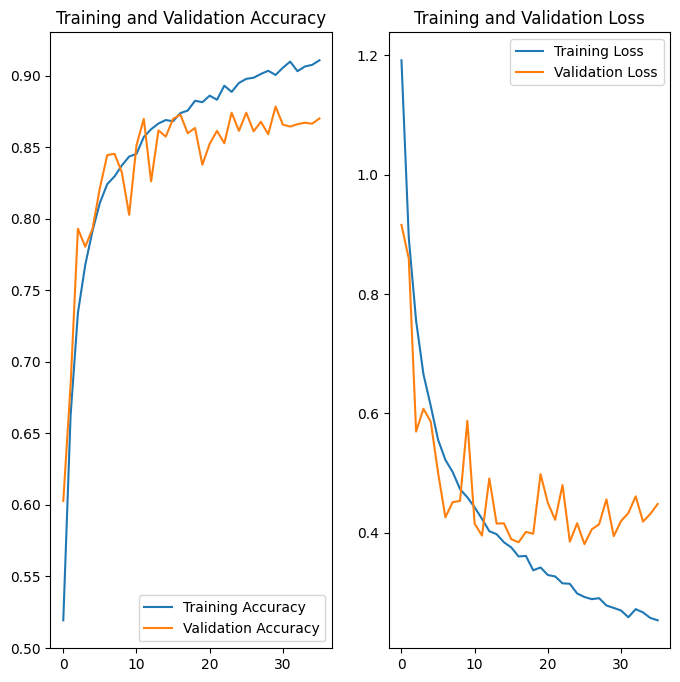

In [10]:
acc = network_history.history['accuracy']
val_acc = network_history.history['val_accuracy']

loss = network_history.history['loss']
val_loss = network_history.history['val_loss']

epochs_range = range(len(network_history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

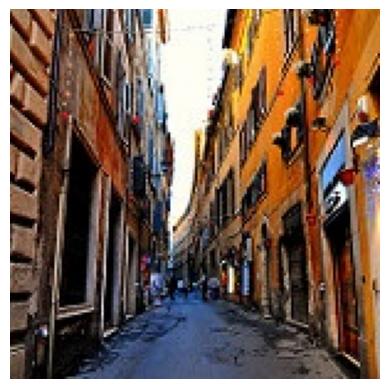

1/1 [==============================] - 0s 247ms/step
This image most likely belongs to street with a 35.20% confidence.


In [11]:
model = tf.keras.models.load_model(os.path.join(model_path, "model.hdf5"))

X_test = os.path.join(data_path, "seg_pred/seg_pred/700.jpg")



img = tf.keras.utils.load_img(X_test, target_size=(150, 150))

plt.axis('off')
plt.imshow(img)
plt.show()

img = tf.keras.utils.img_to_array(img).reshape(1, 150, 150, 3)

predictions = model.predict(img)
score = tf.nn.softmax(predictions[0])

print(f"This image most likely belongs to {class_names[np.argmax(score)]} with a {(100 * np.max(score)):.2f}% confidence.")